In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np
from numpy import array
import pandas as pd
import cv2
from glob import glob
import PIL
import time
from tqdm import tqdm
import os
import seaborn as sns
import shutil

2024-04-23 17:42:54.785462: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-23 17:42:54.807291: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-23 17:42:54.808740: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-23 17:42:55.216035: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
import re
# Read in the images data
images = pd.read_csv('../datasets/images_dataset_clean4.csv')

# Read in the reports data 
reports = pd.read_csv('../datasets/report_dataset_clean4.csv')

# Merge the images and reports data on the ID column
df = pd.merge(images, reports, on='id')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3012 entries, 0 to 3011
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              3012 non-null   int64  
 1   filename        3012 non-null   object 
 2   image_path      3012 non-null   object 
 3   report_file     3012 non-null   object 
 4   body_part       3012 non-null   object 
 5   content         3012 non-null   object 
 6   conclusion      3012 non-null   object 
 7   disease_status  3012 non-null   int64  
 8   disease_type    1721 non-null   object 
 9   location        0 non-null      float64
dtypes: float64(1), int64(2), object(7)
memory usage: 235.4+ KB


In [4]:
df.head(5)

,id,filename,image_path,report_file,body_part,content,conclusion,disease_status,disease_type,location
0,1,abodemen_3_posisi-2310200157_Series_1001-23102...,../datasets/radiology_clean/abodemen_3_posisi/...,abodemen_3_posisi-2310200157_Series_1001-23102...,abdomen,preperitoneal fat dan otot psoas line simetris...,tidak tampak kelainan radiologik.,0,NaN,NaN
1,1,abodemen_3_posisi-2310200157_Series_1001-23102...,../datasets/radiology_clean/abodemen_3_posisi/...,abodemen_3_posisi-2310200157_Series_1001-23102...,abdomen,preperitoneal fat dan otot psoas line simetris...,tidak tampak kelainan radiologik.,0,NaN,NaN
2,1,abodemen_3_posisi-2310200157_Series_1001-23102...,../datasets/radiology_clean/abodemen_3_posisi/...,abodemen_3_posisi-2310200157_Series_1001-23102...,abdomen,preperitoneal fat dan otot psoas line simetris...,tidak tampak kelainan radiologik.,0,NaN,NaN
3,2,abodemen_3_posisi-2310220005_00001-2310220005_...,../datasets/radiology_clean/abodemen_3_posisi/...,abodemen_3_posisi-2310220005_00001-report-1.txt,abdomen,preperitoneal fat dan otot psoas line simetris...,dilatasi ringan usus pada regio abdomen kanan ...,1,dilatasi ringan usus pada regio abdomen kanan ...,NaN
4,2,abodemen_3_posisi-2310220005_00001-2310220005_...,../datasets/radiology_clean/abodemen_3_posisi/...,abodemen_3_posisi-2310220005_00001-report-1.txt,abdomen,preperitoneal fat dan otot psoas line simetris...,dilatasi ringan usus pada regio abdomen kanan ...,1,dilatasi ringan usus pada regio abdomen kanan ...,NaN


In [5]:
# Count the number of NaN values in the 'content' column
nan_content_count = df['content'].isna().sum()
print(f"Number of NaN values in the 'content' column: {nan_content_count}")

# Count the number of NaN values in the 'conclusion' column
nan_conclusion_count = df['conclusion'].isna().sum()
print(f"Number of NaN values in the 'conclusion' column: {nan_conclusion_count}")

Number of NaN values in the 'content' column: 0
Number of NaN values in the 'conclusion' column: 0


In [6]:
print(df.groupby('body_part').size())

body_part
abdomen                   277
ankle                     102
antebrachii                85
bahu                       79
cruris                    114
cubiti                     43
femur                     111
genu                      343
hip_joint                  75
humerus                    86
kepala                     56
manus                     102
os_sacro_coccygeus         29
pedis                     157
pelvis                     81
thorax                    406
vertebra_cervical         186
vertebra_lumbosakral      470
vertebra_thoracolumbal    104
wrist                     106
dtype: int64


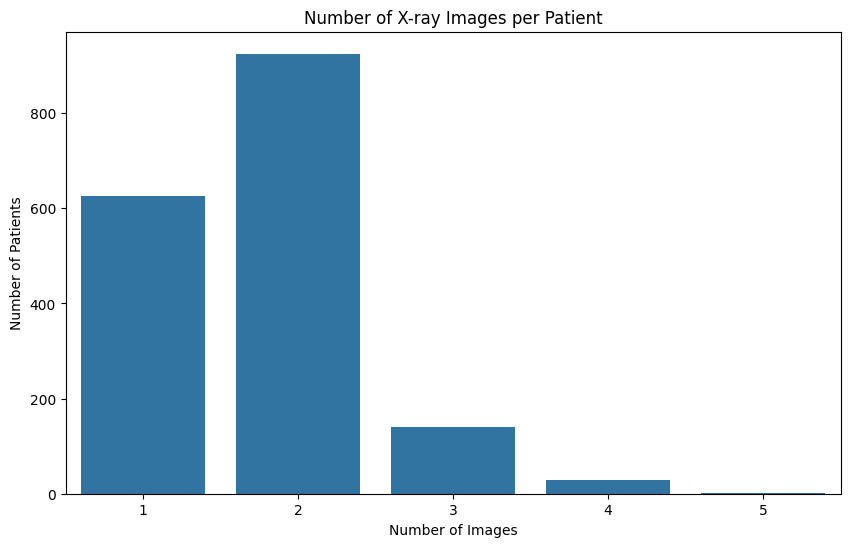

In [7]:
# Count the number of images per patient
images_per_patient = df['id'].value_counts()

# Convert from Series to Dataframe
images_per_patient_df = images_per_patient.reset_index()

# Specify columns
images_per_patient_df.columns = ['patient_id', 'image_count']

# Plot the distribution of images per patient using countplot
plt.figure(figsize=(10, 6))
sns.countplot(x='image_count', data=images_per_patient_df)
plt.xlabel('Number of Images')
plt.ylabel('Number of Patients')
plt.title('Number of X-ray Images per Patient')
plt.show()

In [8]:
def show_image_normal(loc):
    img = cv2.imread(df['image_path'].loc[loc])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
    plt.imshow(img)
    plt.title(df['image_path'].loc[loc], fontsize=9)
    plt.show()
    print(f"Image path: {df['image_path'].loc[loc]}")

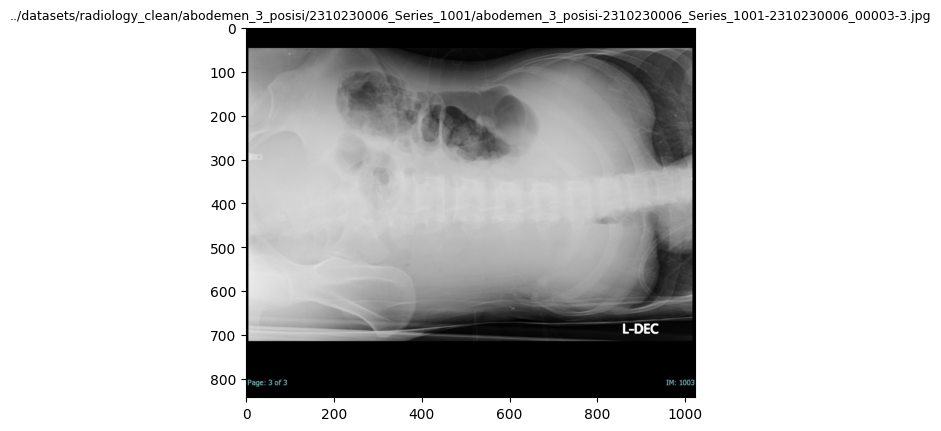

Image path: ../datasets/radiology_clean/abodemen_3_posisi/2310230006_Series_1001/abodemen_3_posisi-2310230006_Series_1001-2310230006_00003-3.jpg


In [9]:
show_image_normal(11)

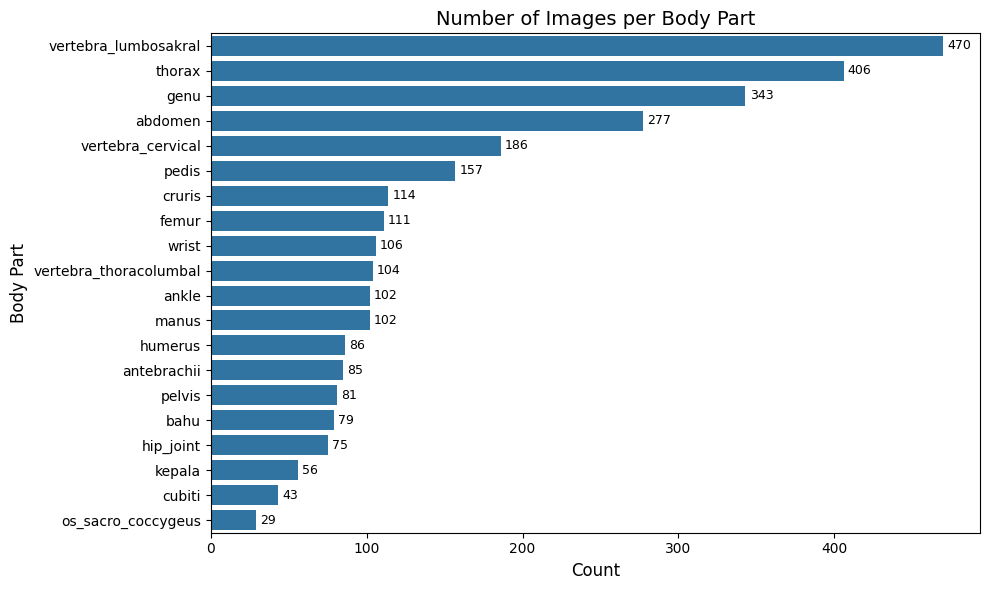

In [10]:
plt.figure(figsize=(10, 6))  # Increase the figure size for better readability
ax = sns.countplot(data=df, y='body_part', order=df['body_part'].value_counts().index)
plt.ylabel('Body Part', fontsize=12)  # Corrected label for y-axis
plt.xlabel('Count', fontsize=12)  # Corrected label for x-axis
plt.title('Number of Images per Body Part', fontsize=14)  # Updated plot title
plt.xticks(rotation=0)  # No need to rotate x-axis labels in a horizontal countplot

# Annotating the bars with the count values
for bar in ax.patches:
    width = bar.get_width()  # Changed height to width for horizontal countplot
    ax.annotate(f'{int(width)}',
                xy=(width, bar.get_y() + bar.get_height() / 2),
                xytext=(3, 0),  # 3 points horizontal offset
                textcoords="offset points",
                ha='left',
                va='center',
                fontsize=9)
    
plt.tight_layout()  # Adjust the layout
plt.show()

In [11]:
print(f"Number of classes in body part: {df['body_part'].nunique()}")

Number of classes in body part: 20


In [12]:
df.drop(columns=["filename", "report_file", "content", "conclusion", "disease_type","disease_status"], inplace=True)
df = df.rename(columns={'id': 'patient_id'})

df.head(5)

,patient_id,image_path,body_part,location
0,1,../datasets/radiology_clean/abodemen_3_posisi/...,abdomen,NaN
1,1,../datasets/radiology_clean/abodemen_3_posisi/...,abdomen,NaN
2,1,../datasets/radiology_clean/abodemen_3_posisi/...,abdomen,NaN
3,2,../datasets/radiology_clean/abodemen_3_posisi/...,abdomen,NaN
4,2,../datasets/radiology_clean/abodemen_3_posisi/...,abdomen,NaN


In [13]:
import tensorflow as tf
from keras.models import Model, Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, Dense, GlobalAveragePooling2D
from keras.layers import Flatten, Concatenate, Dropout, BatchNormalization
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.regularizers import l2
from keras import backend as K
import numpy as np
import os
from tensorflow.keras.applications import InceptionV3

base_model = InceptionV3(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=(224, 224, 3)
)

# freeze all the layers
for layer in base_model.layers:
    layer.trainable = False
 
base_model.summary()

2024-04-23 17:42:57.179187: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-04-23 17:42:57.179207: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: csbui
2024-04-23 17:42:57.179210: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: csbui
2024-04-23 17:42:57.179288: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 550.54.14
2024-04-23 17:42:57.179302: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: NOT_FOUND: could not find kernel module information in driver version file contents: "NVRM version: NVIDIA UNIX Open Kernel Module for x86_64  550.54.14  Release Build  (dvs-builder@U16-A24-2-2)  Thu Feb 22 01:44:50 UTC 2024
GCC version:  gcc version 12.3.0 (Ubuntu 12.3.0-1ubuntu1~22.04

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 111, 111, 32)         0         ['batch_normalizati

In [14]:
input_tensor = Input(shape=(224, 224, 3), name="input_layer")

x = base_model(input_tensor, training=False)  # training=False to avoid updating batch norm statistics

# x = Conv2D(32, (1, 1), activation='relu', padding='same')(x)

# x = Conv2D(32, (1, 1), activation='relu', padding='same')(x)
# x = Conv2D(32, (1, 1), activation='relu', padding='same')(x)

# x = Dropout(0.3)(x)

x = GlobalAveragePooling2D()(x)

x = Dense(1024, activation='relu')(x)  
x = Dropout(0.3)(x)

# x = Dense(1024, activation='relu')(x)  
# x = Dropout(0.3)(x)

# x = Dense(512, activation='relu')(x)  
# x = Dropout(0.4)(x)

# x = Dense(1024, activation='relu')(x)  
# x = Dropout(0.4)(x)


# x = Dense(512, activation='relu')(x)  
# x = Dropout(0.4)(x) 

# Hidden dense layer for multiclass classification
hidden_multiclass = Dense(units=32, activation='relu')(x)

# multiclass classification
multiclass_output = Dense(20, activation='softmax', name='multiclass_output')(hidden_multiclass)

# model with two output layers: binary & multiclass classification
model = Model(inputs=input_tensor, outputs=multiclass_output)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 32)                32800     
                                                             

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


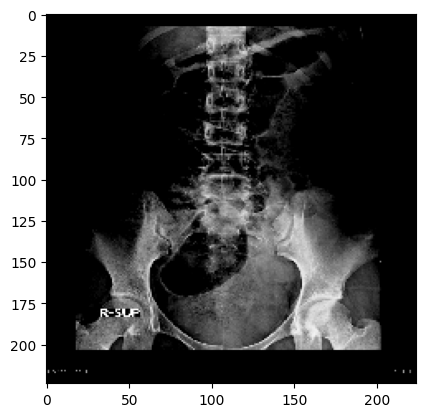

In [15]:
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator


def preprocess_image(img_path):

    # Load a grayscale image
    img = load_img(img_path, color_mode='grayscale', target_size=(224, 224))
    
    # Convert the image to a numpy array
    img_array = img_to_array(img)
    
    # Replicate the grayscale channel three times to create a pseudo-RGB image
    pseudo_rgb_img = np.repeat(img_array, 3, axis=2)
    
    # Preprocess the input image for VGG19
    processed_img = preprocess_input(pseudo_rgb_img)

    return processed_img

img = preprocess_image('../datasets/radiology_clean/abodemen_3_posisi/2310240157_Series_1001/abodemen_3_posisi-2310240157_Series_1001-2310240157_00001-1.jpg')  # Convert from BGR to RGB
plt.imshow(img)  # Convert to uint8 to ensure valid pixel range
plt.show()
# print(img.shape)

In [16]:
BUFFER_SIZE = 5000
BATCH_SIZE = 128

In [17]:
def find_duplicates(list1, list2):
    set1 = set(list1)
    set2 = set(list2)
    duplicates = set1.intersection(set2)
    return list(duplicates)

In [18]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import math

label_encoder = LabelEncoder()

def preprocess_data(data):
    X = []
    y = []

    for _, row in data.iterrows():
        img_path = row['image_path']
        bodypart_label = row['body_part']
        
        img = preprocess_image(img_path)

        X.append(img)  
        y.append(bodypart_label)

    # Convert lists to numpy arrays
    X = np.array(X)
    y = label_encoder.fit_transform(y)
    num_classes = len(label_encoder.classes_)
    y = to_categorical(y, num_classes=num_classes)
    
    return X, y
    
# df_train_val, df_test = train_test_split(df, test_size=0.2, stratify=df['body_part'], random_state=42)
df_train_val = pd.read_csv('./df_train_val_multiclass_1.csv')
df_test = pd.read_csv('./df_test_multiclass_1.csv')
# Preprocess the held-out test set
# X_test, y_test = preprocess_data(df_test)

In [19]:
# df_test.to_csv('df_test_multiclass_1.csv', index=False) 

In [20]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [21]:
# from sklearn.model_selection import train_test_split, StratifiedKFold
# from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, f1_score
# from sklearn.utils.class_weight import compute_class_weight
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from sklearn.utils import resample

# # Define your ImageDataGenerator with augmentation options
# datagen = ImageDataGenerator(
#     rotation_range=10,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     zoom_range=0.1,
#     fill_mode='nearest'
# )

# # Split the dataset into training and validation sets
# train_df, val_df = train_test_split(df_train, test_size=0.25, stratify=df_train['body_part'], random_state=42)

# excluded_body_parts = ['genu', 'vertebra_lumbosakral', 'thorax', 'abdomen']
# df_to_oversample = train_df[~train_df['body_part'].isin(excluded_body_parts)]

# df_no_oversample = train_df[train_df['body_part'].isin(excluded_body_parts)]

# oversampled_data = pd.DataFrame()
# for body_part, group in df_to_oversample.groupby('body_part'):
#     # Set different oversampling targets based on the body part
#     if body_part in ['os_sacro_coccygeus', 'cubiti']:
#         n_samples_to_add = len(group) + 150
#     else:
#         n_samples_to_add = len(group) + 100

#     oversampled_group = resample(group,
#                                  replace=True,
#                                  n_samples=n_samples_to_add,
#                                  random_state=123)

#     oversampled_data = pd.concat([oversampled_data, oversampled_group])

# # Combine the oversampled data with the excluded parts
# df_combined = pd.concat([df_no_oversample, oversampled_data])

# # Shuffle the combined dataset
# train_df = df_combined.sample(frac=1, random_state=42).reset_index(drop=True)

# plt.figure(figsize=(10, 6))  # Increase the figure size for better readability
# ax = sns.countplot(data=train_df, y='body_part', order=train_df['body_part'].value_counts().index)
# plt.ylabel('Body Part', fontsize=12)  # Corrected label for y-axis
# plt.xlabel('Count', fontsize=12)  # Corrected label for x-axis
# plt.title('Number of Images per Body Part', fontsize=14)  # Updated plot title
# plt.xticks(rotation=0)  # No need to rotate x-axis labels in a horizontal countplot

# # Annotating the bars with the count values
# for bar in ax.patches:
#     width = bar.get_width()  # Changed height to width for horizontal countplot
#     ax.annotate(f'{int(width)}',
#                 xy=(width, bar.get_y() + bar.get_height() / 2),
#                 xytext=(3, 0),  # 3 points horizontal offset
#                 textcoords="offset points",
#                 ha='left',
#                 va='center',
#                 fontsize=9)
    
# plt.tight_layout()  # Adjust the layout
# plt.show()

# # Preprocess the training and validation data
# X_train, y_train = preprocess_data(train_df)
# X_val, y_val = preprocess_data(val_df)

# y_train_label = np.argmax(y_train, axis=1)

# # Count the number of images for each label in the multiclass task for the train data
# # argmax(axis=1) to convert one-hot encoded labels to their original integer labels
# unique_multiclass, counts_multiclass = np.unique(y_train_label, return_counts=True)
# train_multiclass_label_counts = dict(zip(unique_multiclass, counts_multiclass))
# print("Train data multiclass label counts:", train_multiclass_label_counts)

# # Count the number of images for each label in the multiclass task for the test data
# unique_multiclass, counts_multiclass = np.unique(y_train_label, return_counts=True)
# test_multiclass_label_counts = dict(zip(unique_multiclass, counts_multiclass))
# print("Test data multiclass label counts:", test_multiclass_label_counts)

# train_dataset = datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)

# # Compute class weights
# class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_label), y=y_train_label)

# # Convert class weights to a dictionary format
# class_weights_dict = dict(enumerate(class_weights))

# # Compile the model
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# # Define EarlyStopping
# early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# # Fit the model
# history = model.fit(
#     train_dataset,
#     steps_per_epoch=len(X_train) // BATCH_SIZE,
#     epochs=50,
#     validation_data=(X_val, y_val),
#     class_weight=class_weights_dict,
#     callbacks=[early_stop]
# )

In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, f1_score, confusion_matrix, classification_report
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import resample
from sklearn.utils.class_weight import compute_class_weight

# Get the total number of samples in the DataFrame
total_samples = len(df_train_val)

# Divide the indices into three equal parts
part_size = total_samples // 3

# Define the indices for each part
part1_indices = np.arange(0, part_size)
part2_indices = np.arange(part_size, 2 * part_size)
part3_indices = np.arange(2 * part_size, total_samples)

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Define your ImageDataGenerator with augmentation options
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest'
)

fold_no = 1
all_true_labels = []
all_predictions = []
all_train_loss = []
all_train_accuracy = []
all_val_loss = []
all_val_accuracy = []
for train, test in skf.split(df_train_val['image_path'], df_train_val['body_part']):
    print(f"Training on fold {fold_no}...")
    # Split the data
    if fold_no == 1:
        train_indices = np.concatenate((part1_indices, part2_indices))
        test_indices = part3_indices
    elif fold_no == 2:
        train_indices = np.concatenate((part2_indices, part3_indices))
        test_indices = part1_indices
    else:
        train_indices = np.concatenate((part1_indices, part3_indices))
        test_indices = part2_indices
    
    train_df = df_train_val.iloc[train_indices]
    test_df = df_train_val.iloc[test_indices]

    # Select one-third of the remaining training data for the validation set
    train_df, val_df = train_test_split(train_df, test_size=1/3, random_state=42)
    
    excluded_body_parts = ['genu', 'vertebra_lumbosakral', 'thorax', 'abdomen']
    df_to_oversample = train_df[~train_df['body_part'].isin(excluded_body_parts)]
    df_no_oversample = train_df[train_df['body_part'].isin(excluded_body_parts)]
    
    oversampled_data = pd.DataFrame()
    for body_part, group in df_to_oversample.groupby('body_part'):
        # Set different oversampling targets based on the body part
        if body_part in ['os_sacro_coccygeus', 'cubiti']:
            n_samples_to_add = len(group) + 150
        else:
            n_samples_to_add = len(group) + 100
    
        oversampled_group = resample(group,
                                     replace=True,
                                     n_samples=n_samples_to_add,
                                     random_state=123)
    
        oversampled_data = pd.concat([oversampled_data, oversampled_group])

    # Combine the oversampled data with the excluded parts
    df_combined = pd.concat([df_no_oversample, oversampled_data])
    
    # Shuffle the combined dataset
    train_df = df_combined.sample(frac=1, random_state=42).reset_index(drop=True)

    concatenated_paths_test_list = test_df['image_path'].tolist()

    concatenated_paths_train_list = train_df['image_path'].tolist()
    
    concatenated_paths_val_list = val_df['image_path'].tolist()

    print(find_duplicates(concatenated_paths_train_list, concatenated_paths_test_list))
    print(find_duplicates(concatenated_paths_val_list, concatenated_paths_test_list))
        
    # Preprocess the data
    X_train, y_train = preprocess_data(train_df)
    X_val, y_val = preprocess_data(val_df)
    X_test, y_test = preprocess_data(test_df)

    train_dataset = datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)
    
    def val_generator():
        for i in range(len(X_val)):
            img = X_val[i]
            label = y_val[i]
            yield img, label

    # Evaluate the model on the held-out test set (only after choosing the final model)
    val_dataset = tf.data.Dataset.from_generator(
        val_generator,
        output_signature=(
            tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(20,), dtype=tf.float32),
        )
    ).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    
    # Compute class weights
    y_train_int_labels = np.argmax(y_train, axis=1)
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_int_labels), y=y_train_int_labels)
    class_weights_dict = {i: weight for i, weight in zip(np.unique(y_train_int_labels), class_weights)}
    
    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    # Define EarlyStopping
    # early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',  # Change to 'val_accuracy' or another metric if monitoring accuracy
        patience=5,  # Adjust based on how many epochs you're willing to wait without improvement
        mode='min',  # 'min' for loss, 'max' for accuracy
        verbose=1,  # Print log messages when stopping
        restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored quantity
    )
    
    # Fit the model
    history = model.fit(
        train_dataset,
        epochs=50,
        validation_data=val_dataset,
        class_weight=class_weights_dict,
        callbacks=[early_stop]
    )

    all_train_loss.append(history.history['loss'])
    all_train_accuracy.append(history.history['accuracy'])
    all_val_loss.append(history.history['val_loss'])
    all_val_accuracy.append(history.history['val_accuracy'])
    
    # Now you have validation results, and you can use them to analyze the performance.
    val_predictions = model.predict(val_dataset)
    val_predicted_labels = np.argmax(val_predictions, axis=1)
    val_true_labels = np.argmax(y_val, axis=1)  

    print(f'Fold {fold_no}: Performance on Validation Data')
    # Calculate the accuracy score
    val_accuracy = accuracy_score(val_true_labels, val_predicted_labels)
    print(f'Val accuracy: {val_accuracy:.2f}')
    
    sensitivity = recall_score(val_true_labels, val_predicted_labels, average='macro')
    print(f'Val Sensitivity: {sensitivity:.2f}')
    
    # Calculate the ROC-AUC score
    val_auc = roc_auc_score(val_true_labels, val_predictions, multi_class='ovo')
    print(f'Val ROC-AUC: {val_auc:.2f}')
    
    val_f1_score = f1_score(val_true_labels, val_predicted_labels, average='weighted')
    print(f'Val F1 score (weighted average): {val_f1_score:.2f}')

    def test_generator():
        for i in range(len(X_test)):
            img = X_test[i]
            label = y_test[i]
            yield img, label

    # Evaluate the model on the held-out test set (only after choosing the final model)
    test_dataset = tf.data.Dataset.from_generator(
        test_generator,
        output_signature=(
            tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(20,), dtype=tf.float32),
        )
    ).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    # Make predictions on the test dataset
    predictions = model.predict(test_dataset)

    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = np.argmax(y_test, axis=1)  

    all_true_labels.append(true_labels)
    all_predictions.append(predictions)
    
    # Calculate the accuracy score
    print(f'Fold {fold_no}: Performance on Test Data')
    accuracy = accuracy_score(true_labels, predicted_labels)
    print(f'Test accuracy: {accuracy:.2f}')
    
    sensitivity = recall_score(true_labels, predicted_labels, average='macro')
    print(f'Test sensitivity: {sensitivity:.2f}')
    
    # Calculate the ROC-AUC score
    auc = roc_auc_score(true_labels, predictions, multi_class='ovo')
    print(f'Test ROC-AUC: {auc:.2f}')

    test_f1_score = f1_score(true_labels, predicted_labels, average='weighted')
    print(f'Test F1 score (weighted average): {test_f1_score:.2f}')

    # conf_matrix = confusion_matrix(true_labels, predicted_labels)
    # print("Test Confusion Matrix:")
    # print(conf_matrix)

    fold_no += 1

Training on fold 1...
[]
[]
Epoch 1/50
22/22 [==============================] - 33s 1s/step - loss: 0.3006 - accuracy: 0.1090 - val_loss: 0.1724 - val_accuracy: 0.3284
Epoch 2/50
22/22 [==============================] - 36s 2s/step - loss: 0.1613 - accuracy: 0.3523 - val_loss: 0.1193 - val_accuracy: 0.5299
Epoch 3/50
22/22 [==============================] - 37s 2s/step - loss: 0.1231 - accuracy: 0.5758 - val_loss: 0.1101 - val_accuracy: 0.6511
Epoch 4/50
22/22 [==============================] - 29s 1s/step - loss: 0.1020 - accuracy: 0.7079 - val_loss: 0.0926 - val_accuracy: 0.7556
Epoch 5/50
22/22 [==============================] - 25s 1s/step - loss: 0.0817 - accuracy: 0.8051 - val_loss: 0.0810 - val_accuracy: 0.7799
Epoch 6/50
22/22 [==============================] - 25s 1s/step - loss: 0.0705 - accuracy: 0.8394 - val_loss: 0.0730 - val_accuracy: 0.8041
Epoch 7/50
22/22 [==============================] - 25s 1s/step - loss: 0.0607 - accuracy: 0.8693 - val_loss: 0.0665 - val_accuracy:

In [23]:
# print("***Performance on Validation data***")
# # Calculate the accuracy score
# val_predictions = model.predict(X_val)
# predicted_labels = np.argmax(val_predictions, axis=1)
# true_labels =  np.argmax(y_val, axis=1)


# val_accuracy = accuracy_score(true_labels, predicted_labels)
# print(f'Val accuracy: {val_accuracy:.2f}')

# sensitivity = recall_score(true_labels, predicted_labels, average='macro')
# print(f'Val Sensitivity: {sensitivity:.2f}')

# # Calculate the ROC-AUC score
# val_auc = roc_auc_score(true_labels, val_predictions, multi_class='ovo')
# print(f'Val ROC-AUC: {val_auc:.2f}')

# val_f1_score = f1_score(true_labels, predicted_labels, average='weighted')
# print(f'Val F1 score (weighted average): {val_f1_score:.2f}')

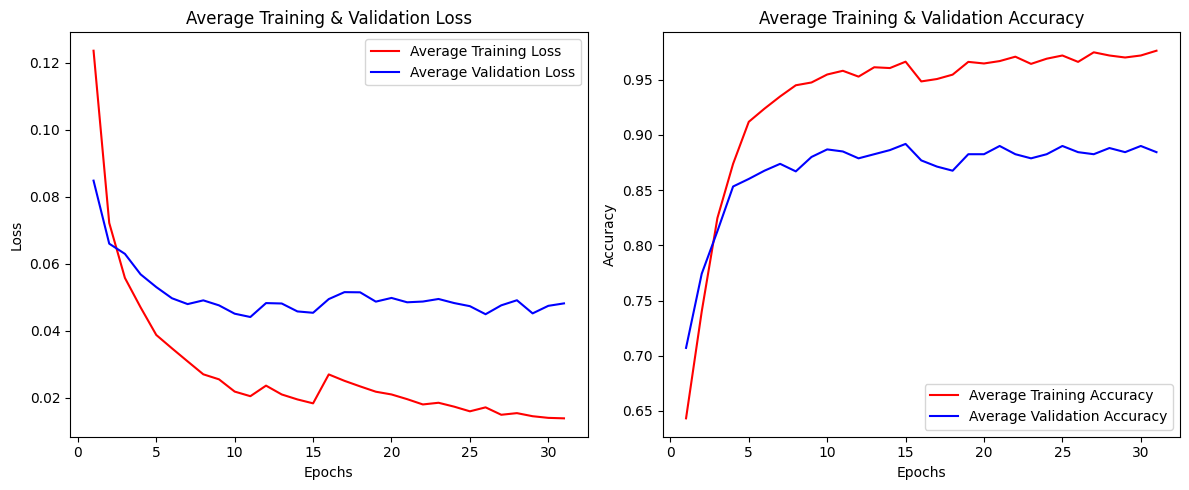

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate the average of the collected metrics
def average_across_folds(metric_list):
    # Find the longest list
    max_length = max(len(metrics) for metrics in metric_list)
    # Extend all lists to max_length
    extended_metrics = [np.pad(metrics, (0, max_length - len(metrics)), 'constant', constant_values=np.nan) for metrics in metric_list]
    # Calculate the mean while ignoring NaNs
    mean_metrics = np.nanmean(np.array(extended_metrics), axis=0)
    return mean_metrics

# Plotting
epochs = range(1, len(average_across_folds(all_train_loss)) + 1)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, average_across_folds(all_train_loss), 'r-', label='Average Training Loss')
plt.plot(epochs, average_across_folds(all_val_loss), 'b-', label='Average Validation Loss')
plt.title('Average Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, average_across_folds(all_train_accuracy), 'r-', label='Average Training Accuracy')
plt.plot(epochs, average_across_folds(all_val_accuracy), 'b-', label='Average Validation Accuracy')
plt.title('Average Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [25]:
# model.save('densenet_multiclass_classification_1.h5')

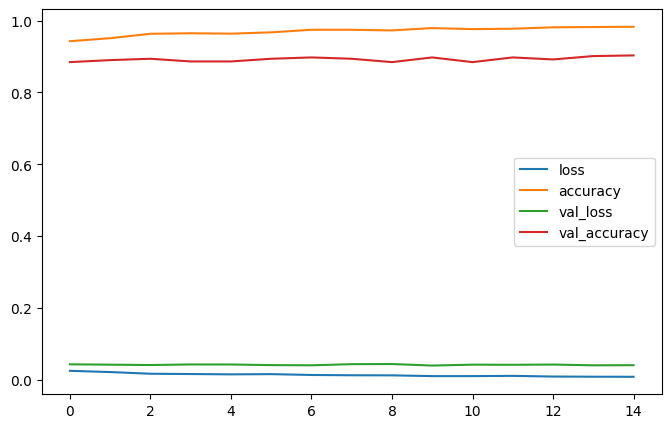

In [26]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

In [27]:
model.save('inception_multiclass_new_4.h5')

/home/radiology/miniconda3/envs/tf-env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [28]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score

X_test, y_test = preprocess_data(df_test)

def test_generator():
    for i in range(len(X_test)):
        img = X_test[i]
        label = y_test[i]
        yield img, label

# Evaluate the model on the held-out test set (only after choosing the final model)
test_dataset = tf.data.Dataset.from_generator(
    test_generator,
    output_signature=(
        tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(20,), dtype=tf.float32),
    )
).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# predict on the test dataset
predictions = model.predict(test_dataset)

# multiclass classification
multiclass_predicted_labels = np.argmax(predictions, axis=1)

# converts one-hot encoded into integer class labels
multiclass_true_labels = np.argmax(y_test, axis=1)  

# multiclass classification accuracy score
multiclass_accuracy = accuracy_score(multiclass_true_labels, multiclass_predicted_labels)
print(f'Test accuracy: {multiclass_accuracy:.2f}')

multiclass_sensitivity = recall_score(multiclass_true_labels, multiclass_predicted_labels, average='macro')
print(f'Test Sensitivity: {multiclass_sensitivity:.2f}')

# Calculate the ROC-AUC score
multiclass_auc = roc_auc_score(multiclass_true_labels, predictions, multi_class='ovo')
print(f'Test ROC-AUC: {multiclass_auc:.2f}')

# multiclass classification F1 score
multiclass_f1_score = f1_score(multiclass_true_labels, multiclass_predicted_labels, average='weighted')
print(f'Test F1 score (weighted average): {multiclass_f1_score:.2f}')

5/5 [==============================] - 4s 749ms/step
Test accuracy: 0.90
Test Sensitivity: 0.83
Test ROC-AUC: 0.99
Test F1 score (weighted average): 0.89


In [29]:
from sklearn.metrics import f1_score, classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

report = classification_report(multiclass_true_labels, multiclass_predicted_labels, target_names=label_encoder.classes_)
print("Classification Report:")
print(report)

Classification Report:
                        precision    recall  f1-score   support

               abdomen       0.90      0.95      0.92        56
                 ankle       1.00      0.95      0.97        20
           antebrachii       0.92      0.71      0.80        17
                  bahu       0.82      0.88      0.85        16
                cruris       0.78      0.91      0.84        23
                cubiti       0.50      0.78      0.61         9
                 femur       0.82      0.82      0.82        22
                  genu       0.97      0.93      0.95        69
             hip_joint       0.90      0.60      0.72        15
               humerus       0.93      0.82      0.88        17
                kepala       0.85      1.00      0.92        11
                 manus       0.95      1.00      0.98        20
    os_sacro_coccygeus       1.00      0.17      0.29         6
                 pedis       1.00      1.00      1.00        32
                

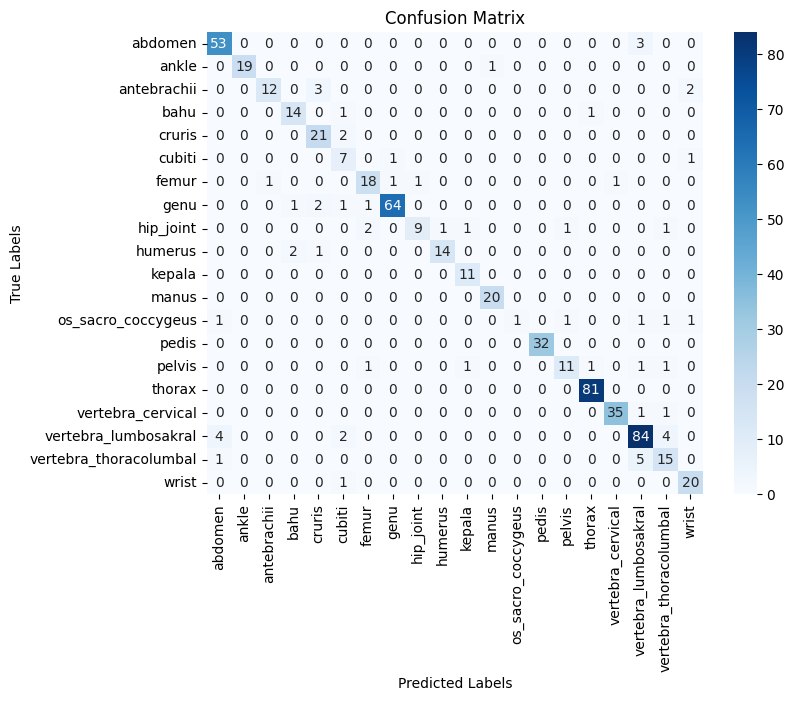

In [30]:
from sklearn.metrics import confusion_matrix

class_names = label_encoder.classes_

# Calculate the confusion matrix for binary classification
conf_matrix = confusion_matrix(multiclass_true_labels, multiclass_predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [31]:
import random

def predict_multiclass(test_dataset, model, label_encoder= None):
    # convert the test dataset to a list of batches
    batches = list(test_dataset.unbatch().map(lambda x, y: (x, y)).batch(1).as_numpy_iterator())

    # randomly select a batch (one image and its label)
    random_index = random.randint(0, len(batches) - 1)
    img, true_multiclass_label = batches[random_index]

    img_batch = np.expand_dims(img[0], axis=0)
    prediction = model.predict(img_batch)
    # find max value in array of prediction probabilities
    predicted_multiclass_label = np.argmax(prediction)

    # convert integer labels to class names
    predicted_class_name = label_encoder.inverse_transform([predicted_multiclass_label])[0]
    true_class_name = label_encoder.inverse_transform([np.argmax(true_multiclass_label)])[0]

    print(f"Predicted class: {predicted_class_name}, True class: {true_class_name}")

    print(f"Predicted multiclass label: {predicted_multiclass_label}, True multiclass label: {np.argmax(true_multiclass_label)}")

In [32]:
predict_multiclass(test_dataset, model, label_encoder)

1/1 [==============================] - 1s 539ms/step
Predicted class: manus, True class: manus
Predicted multiclass label: 11, True multiclass label: 11


In [33]:
import random

skip_body_part = ['abdomen', 'kepala', 'os_sacro_coccygeus', 'pelvis', 'thorax', 'vertebra_cervical', 'vertebra_lumbosakral', 'vertebra_thoracolumbal']
prev_id = None

path_mask_l = '../datasets/ocr_mask/mask_L.jpg'
path_mask_l2 = '../datasets/ocr_mask/mask_L_2.jpg'
path_mask_l3 = '../datasets/ocr_mask/mask_L_3.jpg'
path_mask_l4 = '../datasets/ocr_mask/mask_L_4.jpg'
path_mask_l_white = '../datasets/ocr_mask/mask_L_white.jpg'
path_mask_r = '../datasets/ocr_mask/mask_R.jpg'
path_mask_r2 = '../datasets/ocr_mask/mask_R_2.jpg'
path_mask_r3 = '../datasets/ocr_mask/mask_R_3.jpg'
path_mask_r4 = '../datasets/ocr_mask/mask_R_4.jpg'
path_mask_r5 = '../datasets/ocr_mask/mask_R_5.jpg'
path_mask_r_white = '../datasets/ocr_mask/mask_R_white.jpg'


template_l = cv2.imread(path_mask_l)
template_l2 = cv2.imread(path_mask_l2)
template_l3 = cv2.imread(path_mask_l3)
template_l4 = cv2.imread(path_mask_l4)
template_l_white = cv2.imread(path_mask_l_white)
template_r = cv2.imread(path_mask_r)
template_r2 = cv2.imread(path_mask_r2)
template_r3 = cv2.imread(path_mask_r3)
template_r4 = cv2.imread(path_mask_r4)
template_r5 = cv2.imread(path_mask_r5)
template_r_white = cv2.imread(path_mask_r_white)


template_images = [template_l, template_l2, template_l3, template_l4, template_l_white, template_r, template_r2, template_r3, template_r4, template_r5, template_r_white]

def detect_position(image, template_images=template_images):
    idx_pos = []
    for idx, template in enumerate(template_images):
        template_gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)

        # template matching
        match_result = cv2.matchTemplate(image, template_gray, cv2.TM_CCOEFF_NORMED)
        
        # get max_val to know the detection confidence
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(match_result)

        # if confident more than 85% return the idx
        if max_val >= 0.85:
            idx_pos.append(idx)
    return idx_pos


def predict_multiclass_with_position(df_test, model, label_encoder, template_images):
    # Select one index at random
    random_index = np.random.choice(df_test.index)

    # Get the random row
    random_row = df_test.loc[random_index]

    true_multiclass_label = random_row['body_part']
    preprocessed_img = preprocess_image(random_row['image_path'])

    # Predict body part
    img_batch = np.expand_dims(preprocessed_img, axis=0)
    prediction = model.predict(img_batch)
    
    # Find max value in array of prediction probabilities
    predicted_multiclass_label = np.argmax(prediction)
    # Convert integer labels to class names
    predicted_class_name = label_encoder.inverse_transform([predicted_multiclass_label])[0]
    true_class_name = true_multiclass_label

    # Get all patients of the same patient id for template matching
    random_id = random_row['patient_id']
    rows_with_same_id = df_test[df_test['patient_id'] == random_id]

    # Perform template matching to detect the position
    if predicted_class_name in skip_body_part: 
        combined_result = predicted_class_name
    else:
        position_list = []
        for index, row in rows_with_same_id.iterrows():
            image = cv2.imread(row['image_path'])
            
            plt.imshow(image)
            plt.show()
            
            image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).astype(np.uint8)
            idx_pos = detect_position(image_gray)

            # append position
            if any(i in idx_pos for i in range(5)) and any(i in idx_pos for i in range(5, 11)):
                position_list.append('right')
                position_list.append('left')
            elif any(i in idx_pos for i in range(5)):
                position_list.append('left')
            elif any(i in idx_pos for i in range(5, 11)):
                position_list.append('right')

        if len(position_list) > 0:            
            if 'right' in position_list and 'left' in position_list:
                position = 'bilateral'
            elif 'right' in position_list:
                position = 'dextra'
            elif 'left' in position_list:
                position = 'sinistra'
            else:
                position = 'not detected'
        combined_result = f"{predicted_class_name} {position}"

    print(f"Predicted class: {predicted_class_name}, True class: {true_class_name}")
 
    print(f"Result: {combined_result}")

    return combined_result, predicted_class_name, true_class_name


In [34]:
predict_multiclass_with_position(df_test, model, label_encoder,template_images)

1/1 [==============================] - 0s 20ms/step
Predicted class: vertebra_cervical, True class: vertebra_cervical
Result: vertebra_cervical


('vertebra_cervical', 'vertebra_cervical', 'vertebra_cervical')